# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [1]:
import observation_model
import math
import openfst_python as fst

from subprocess import check_call
from IPython.display import Image

import glob
import os
import wer


In [2]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
        self.forward = 0

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        self.forward +=1
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
        
        return self.forward
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)
    


In [3]:
def show_wfst(f):
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=500','tmp.dot','-o','tmp.png'])
    Image(filename='tmp.png')

In [4]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            if line[0] in lex.keys():
                lex[line[0] + "_"] = line[1:] 
            else:
                lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

def generate_phone_wfst(f, start_state, phone, n, loop_w, next_w ):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    sl_weight = fst.Weight('log', -math.log(loop_w))  # weight for self-loop
    next_weight = fst.Weight('log', -math.log(next_w)) # weight to next state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, 0, next_weight, next_state))    # changed to 0 ! 
       
        current_state = next_state
        
    return current_state

def generate_word_wfst(word):
    """ Generate a WFST for any word in the lexicon, composed of 3-state phone WFSTs.
        This will currently output word labels.  
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        word (str): the word to generate
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst('log')
    
    # create the start state
    start_state = f.add_state()
    f.set_start(start_state)
    certain_weight =  fst.Weight('log', -math.log(1))
    
    current_state = start_state
    
    # iterate over all the phones in the word
    for (i,phone) in enumerate(lex[word]):   # will raise an exception if word is not in the lexicon
        
        current_state = generate_phone_wfst(f, current_state, phone, 3)
    
        if i == len(lex[word]) - 1:
            next_state = f.add_state()
            f.add_arc(current_state, fst.Arc(in_label, word_table.find(word), certain_weight, current_state))
            
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f

def generate_word_sequence_recognition_wfst(n, probs, loop_w, next_w):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')

    #even_weight = fst.Weight('log', -math.log(1/len(lex)))
    
    #even_weight = fst.Weight('log', -math.log(1/len(lex)))
    #reduced_weight = fst.Weight('log', -math.log(1/(5*len(lex))))
    
    #this one used before
    next_weight = fst.Weight('log', -math.log(0.1))
    #next_weight = fst.Weight('log', 0)
    #testing this one 
    
    certain_weight =  fst.Weight('log', -math.log(1))
    
    # create a single start state
    start_state = f.add_state()
    #f.add_arc(start_state, fst.Arc(0, 0, fst.Weight('log', -math.log(0.3)), start_state))
    
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()

        f.add_arc(start_state, fst.Arc(0, 0, fst.Weight('log', -math.log(probs[word])), current_state))
        
        for (i, phone) in enumerate(phones): 
            current_state = generate_phone_wfst(f, current_state, phone, n, loop_w , next_w)
        # note: new current_state is now set to the final state of the previous phone WFST
            if i == len(lex[word]) - 1:

                next_state = f.add_state()
                f.add_arc(current_state, fst.Arc(0, word_table.find(word.replace("_", "")), certain_weight, next_state))
                current_state= next_state
                
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, next_weight, start_state))
        
    return f



In [5]:
def create_wfst(n, state_table, phone_table, word_probabilities, loop_w = 0.3, next_w = 0.7):
    # word probabilities: a dictionary, to adjust weights. 
    f = generate_word_sequence_recognition_wfst(n, word_probabilities, loop_w, next_w)
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
    return f

In [6]:
even_dict = {}
for word, _ in lex.items():
    even_dict[word] = 0.1

In [7]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    

    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


These are all for different combinations of the self-loop / next state weights 

In [8]:
word_table, phone_table, state_table = generate_symbol_tables(lex)
f = create_wfst(3, state_table, phone_table, even_dict)

In [9]:

# utterance_c = 0
# word_c = 0
# errors_sum = 0
# fr = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav')[:50]:    # replace path if using your own
#         #if utterance_c < 6:                                                            # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         fr += decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c, fr)

In [10]:
# utterance_c = 0
# word_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst(3, state_table, phone_table, even_dict, 0.7, 0.3)
# errors_sum = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                          # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c)

In [11]:
# utterance_c = 0
# word_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst(3, state_table, phone_table, even_dict, 0.5, 0.5)
# errors_sum = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#                                                                     # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c)

In [12]:
# utterance_c = 0
# word_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst(3, state_table, phone_table, even_dict, 0.9, 0.1)
# errors_sum = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#                                                                     # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c)

In [13]:
# utterance_c = 0
# word_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst(3, state_table, phone_table, even_dict, 0.9, 0.1)
# errors_sum = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#     if utterance_c < 10:
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         %time decoder.decode()
#         (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c)

In [14]:
# utterance_c = 0
# word_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst(3, state_table, phone_table, even_dict, 0.9, 0.1)
# errors_sum = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#                                                                     # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c)

In [15]:
# utterance_c = 0
# word_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst(3, state_table, phone_table, even_dict, 0.1, 0.9)
# errors_sum = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#                                                                     # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
        
#         decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace()
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count
# print(errors_sum, utterance_c, word_c)

Number of states for assesing memory

In [16]:
# len(list(f.states()))

In [17]:
# a = 1
# for word, phones in lex.items():
#         a += 3*len(phones) + 2
# a

## Task 1

wfst with unigram probabilities based on counts, instead of even probabilities for all words

In [18]:
c = {}
for word in lex.keys():
    c[word] = 0
c["SUM"] = 0
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
    transcript=read_transcription(wav_file)
    for word in lex.keys():
        count = transcript.count(word)
        c[word] += count
        c["SUM"] += count
        
        
unigram_probs = {}
for w, count in c.items():
    if "_" not in w:
        unigram_probs[w] = count /c["SUM"]
        
unigram_probs

{'a': 0.05834018077239113,
 'of': 0.10230073952341824,
 'peck': 0.11133935907970419,
 'peppers': 0.13475760065735415,
 'peter': 0.12900575184880855,
 'picked': 0.11298274445357437,
 'pickled': 0.11750205423171733,
 'piper': 0.11503697617091208,
 'the': 0.06409202958093672,
 "where's": 0.05464256368118324,
 'SUM': 1.0}

In [19]:
def generate_word_sequence_recognition_wfst_unigram(n, probs):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')

    #even_weight = fst.Weight('log', -math.log(1/len(lex)))
    
    #even_weight = fst.Weight('log', -math.log(1/len(lex)))
    #reduced_weight = fst.Weight('log', -math.log(1/(5*len(lex))))
    next_weight = fst.Weight('log', -math.log(0.05))
    certain_weight =  fst.Weight('log', -math.log(1))
    
    # create a single start state
    start_state = f.add_state()
    #f.add_arc(start_state, fst.Arc(0, 0, fst.Weight('log', -math.log(0.3)), start_state))
    
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()

        f.add_arc(start_state, fst.Arc(0, 0, fst.Weight('log', -math.log(probs[w])), current_state))
        
        for (i, phone) in enumerate(phones): 
            current_state = generate_phone_wfst(f, current_state, phone, n, 0.9, 0.1)
        # note: new current_state is now set to the final state of the previous phone WFST
            if i == len(lex[word]) - 1:

                next_state = f.add_state()
                f.add_arc(current_state, fst.Arc(0, word_table.find(word.replace("_", "")), certain_weight, next_state))
                current_state= next_state
                
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, next_weight, start_state))
        
    return f


def create_wfst_unigram(n, state_table, phone_table, word_probabilities):
    # word probabilities: a dictionary, to adjust weights. 
    f = generate_word_sequence_recognition_wfst_unigram(n, word_probabilities)
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
    return f

In [20]:
# utterance_c = 0
# word_table, phone_table, state_table = generate_symbol_tables(lex)
# f = create_wfst_unigram(3, state_table, phone_table, unigram_probs)
# errors_sum = 0
# word_c = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#                                                                    # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(f, wav_file)
    
#         decoder.decode()
#         if utterance_c < 10:
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             (state_path, words) = decoder.backtrace() 
        
#         transcription = read_transcription(wav_file)                                    
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
    
#         if utterance_c < 3:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         word_c += word_count

# print(errors_sum, utterance_c, word_c)

Adding silence states at the start and between words.

In [21]:
state_table.add_symbol("sil_1")
state_table.add_symbol("sil_2")
state_table.add_symbol("sil_3")
state_table.add_symbol("sil_4")
state_table.add_symbol("sil_5")

56

In [22]:
def generate_sil_wfst(n, word_probabilities, sil_prob = 0.1, ergodic = False):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')

    #even_weight = fst.Weight('log', -math.log(1/len(lex)))
    
    #even_weight = fst.Weight('log', -math.log(1/len(lex)))
    #reduced_weight = fst.Weight('log', -math.log(1/(5*len(lex))))
    next_weight = fst.Weight('log', -math.log(0.1))
    certain_weight =  fst.Weight('log', -math.log(1))
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    #first_silent = f.add_state()
    #last_silent = f.add_state()
    #f.set_final(last_silent)
    
    if ergodic == True:
        sil_states = [0, 0, 0, 0, 0]
        for i in range(5):
            sil_states[i] = f.add_state()
        #start to first
        #f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(sil_prob)),sil_states[0]))
        f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(sil_prob)),sil_states[0]))
        #loop for sil 1
        f.add_arc(sil_states[0], fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(0.9)),sil_states[0]))
        #loop for sil 5
        f.add_arc(sil_states[4], fst.Arc(state_table.find("sil_5"), 0, fst.Weight('log', -math.log(0.9)),sil_states[4]))
        #sil 5 to start state
        f.add_arc(sil_states[4], fst.Arc(0, 0, next_weight, start_state))
        f.set_final(sil_states[4])
    
        for i in [1,2,3]:
            #loop
            f.add_arc(sil_states[i], fst.Arc(state_table.find("sil_" + str(i+1)), 0, fst.Weight('log', -math.log(0.9)),sil_states[i]))
            #to final
            f.add_arc(sil_states[i], fst.Arc(state_table.find("sil_" + str(i+1)), 0, fst.Weight('log', -math.log(0.1)),sil_states[4]))
            #from first
            f.add_arc(sil_states[0], fst.Arc(state_table.find("sil_" + str(i+1)), 0, fst.Weight('log', -math.log(0.1)),sil_states[i]))
        
            for j in [1,2,3]:
                if i != j:
                    f.add_arc(sil_states[i], fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(0.1)),sil_states[j]))

    else:
        sil_states = [0, 0, 0, 0, 0]
        for i in range(5):
            sil_states[i] = f.add_state()
        # leftto right
        #start to first
        f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(sil_prob)),sil_states[0]))
        #f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', 3),sil_states[0]))
        #loop for sil 1
        #f.add_arc(sil_states[0], fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(0.1)),sil_states[0]))
        #loop for sil 5
        f.add_arc(sil_states[4], fst.Arc(state_table.find("sil_5"), 0, fst.Weight('log', -math.log(0.9)),sil_states[4]))
        #sil 5 to start state
        f.add_arc(sil_states[4], fst.Arc(0, 0, next_weight, start_state))
        f.set_final(sil_states[4])

        for j in [0, 1,2,3]:
            #loop
            f.add_arc(sil_states[j], fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', 0.9),sil_states[j]))
            #next
            f.add_arc(sil_states[j], fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', 0.1),sil_states[j+1]))
        
    for word, phones in lex.items():
        current_state = f.add_state()
        
        f.add_arc(start_state, fst.Arc(0, 0, fst.Weight('log', -math.log(word_probabilities[word])), current_state))
        
        for (i, phone) in enumerate(phones): 
            current_state = generate_phone_wfst(f, current_state, phone, n, 0.9, 0.1)
        # note: new current_state is now set to the final state of the previous phone WFST
            if i == len(lex[word]) - 1:

                next_state = f.add_state()
                f.add_arc(current_state, fst.Arc(0, word_table.find(word.replace("_", "")), certain_weight, next_state))
                current_state= next_state
                
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, next_weight, start_state))
        
    return f


In [23]:
s = generate_sil_wfst(3, even_dict, 0.1, ergodic = True)
s.set_input_symbols(state_table)
s.set_output_symbols(word_table)
show_wfst(s)

In [24]:
# s = generate_sil_wfst(3, even_dict, 0.1)
# s.set_input_symbols(state_table)
# s.set_output_symbols(word_table)

# errors_sum = 0
# utterances = 0
# words_no = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#         #if utterances < 10:                                                                       # audio files
#         utterances += 1
#         decoder = MyViterbiDecoder(s, wav_file)
    
#         if utterances < 10:
#             %time decoder.decode()
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             decoder.decode()
#             (state_path, words) = decoder.backtrace()
            
            
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

    
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
    
#         if sum(error_counts) > 10:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) 
#             print(utterances)
#             # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         words_no += word_count
# print(errors_sum, utterances, words_no)


In [25]:
# s = generate_sil_wfst(3, even_dict, 0.1, ergodic = True)
# s.set_input_symbols(state_table)
# s.set_output_symbols(word_table)

# errors_sum = 0
# utterances = 0
# words_no = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#         #if utterances < 10:                                                                       # audio files
#         utterances += 1
#         decoder = MyViterbiDecoder(s, wav_file)
    
#         if utterances < 10:
#             %time decoder.decode()
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             decoder.decode()
#             (state_path, words) = decoder.backtrace()
            
            
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

    
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
    
#         if sum(error_counts) > 10:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) 
#             print(utterances)
#             # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         words_no += word_count
# print(errors_sum, utterances, words_no)


In [26]:
# s = generate_sil_wfst(3, even_dict, 0.05)
# s.set_input_symbols(state_table)
# s.set_output_symbols(word_table)

# errors_sum = 0
# utterances = 0
# words_no = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                 # audio files
#         utterances += 1
#         decoder = MyViterbiDecoder(s, wav_file)
    
#         if utterances < 10:
#             %time decoder.decode()
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             decoder.decode()
#             (state_path, words) = decoder.backtrace()
            
            
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

    
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
    
#         if utterances < 4:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count)     # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         words_no += word_count
# print(errors_sum, utterances, words_no)

In [27]:
# s = generate_sil_wfst(3, even_dict, 0.1)
# s.set_input_symbols(state_table)
# s.set_output_symbols(word_table)

# errors_sum = 0
# utterances = 0
# words_no = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#         #if utterances < 10:                                                                       # audio files
#         utterances += 1
#         decoder = MyViterbiDecoder(s, wav_file)
    
#         if utterances < 10:
#             %time decoder.decode()
#             %time (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         else:
#             decoder.decode()
#             (state_path, words) = decoder.backtrace()
            
            
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path

    
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
    
#         if sum(error_counts) > 2:
#             print (words)
#             print(transcription)
#             print(error_counts, word_count) 
#             print(utterances)
#             # you'll need to accumulate these
#         errors_sum += sum(error_counts)
#         words_no += word_count
# print(errors_sum, utterances, words_no)


## Task 2 - Pruning

In [28]:
class PruningViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name, pruning_threshold = 500):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()
        self.threshold = pruning_threshold
        self.skipped = 0
        self.forward = 0

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        #find the best V[t-1]
        best = max(2.3, min(self.V[t-1]))
        for i in self.f.states():
            
            #if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
            if (self.V[t-1][i] < best * self.threshold):   # bigger value means lower probability ! 
                #print(self.V[t-1][i])
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        self.forward +=1
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
            else:
                self.skipped += 1
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
        
        return self.forward
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)
    


In [29]:
# f = generate_word_sequence_recognition_wfst(3, even_dict, 0.9, 0.1 )
# f.set_input_symbols(state_table)
# f.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.5)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, s)

In [30]:
# f = generate_word_sequence_recognition_wfst(3, even_dict, 0.9, 0.1 )
# f.set_input_symbols(state_table)
# f.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.25)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, s)

In [31]:
# f = generate_word_sequence_recognition_wfst(3, even_dict, 0.9, 0.1 )
# f.set_input_symbols(state_table)
# f.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.1)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, s)

In [32]:
# f = generate_word_sequence_recognition_wfst(3, even_dict, 0.9, 0.1 )
# f.set_input_symbols(state_table)
# f.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.05)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, s)

In [33]:
# f = generate_word_sequence_recognition_wfst(3, even_dict, 0.9, 0.1 )
# f.set_input_symbols(state_table)
# f.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.025)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, s)

In [34]:
# f = generate_word_sequence_recognition_wfst(3, even_dict, 0.9, 0.1 )
# f.set_input_symbols(state_table)
# f.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.01)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
#         break
        
# print(errors_sum, utterance_c, words_c, s)

## Task 4

In [35]:
# best performance from experiments

# s = generate_sil_wfst(3, even_dict)
# s.set_input_symbols(state_table)
# s.set_output_symbols(word_table)

# errors_sum = 0
# utterance_c = 0
# words_c = 0
# t = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#         #if utterances < 10:                                                                       # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(s, wav_file)
    
#         if utterance_c < 10:
#             %time t += decoder.decode()
#         else:
#                 t += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, t)

In [36]:
# best performance from experiments
# errors_sum = 0
# utterance_c = 0
# words_c = 0
# t = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(s, wav_file, pruning_threshold =1.1)
    
#         if utterance_c < 10:
#             %time t += decoder.decode()
#         else:
#                 t += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, t)

In [37]:
# errors_sum = 0
# utterance_c = 0
# words_c = 0
# s = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own                                                                     # audio files
#         utterance_c+=1
#         decoder = PruningViterbiDecoder(f, wav_file, pruning_threshold =1.025)
    
#         if utterance_c < 10:
#             %time s += decoder.decode()
#         else:
#                 s += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, s)

In [38]:
"--------------"

'--------------'

In [39]:
def generate_tr_phone_wfst(f, start_state, phone, n, loop_w, next_w ):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    sl_weight = fst.Weight('tropical', -math.log(loop_w))  # weight for self-loop
    next_weight = fst.Weight('tropical', -math.log(next_w)) # weight to next state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, 0, next_weight, next_state))    # changed to 0 ! 
       
        current_state = next_state
        
    return current_state

In [40]:
# bi_lex = ["a", "of", "peck", "peppers", "peter", "picked", "pickled", "piper", "the", "where's", "<s>", "<\s>"]
# bi_word_table = generate_bi_table(bi_lex) 
c = {}
c["SUM"] = 0
bi_count = {}
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
    transcript=read_transcription(wav_file)
#     transcript = "<s> " + transcript + " <\s>"
    bigrams = [b for l in [transcript] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
    for word in lex:
        count = transcript.count(word)
        if word not in c:
            c[word] = 0
        c[word] += count
        c["SUM"] += count
        
    for bigram in bigrams:
        count = bigrams.count(bigram)
        if bigram not in bi_count:
            bi_count[bigram] = 0
        bi_count[bigram] += count
        
unigram_probs = {}
for w, count in c.items():
    if "_" not in w:
        unigram_probs[w] = count /c["SUM"]

bigram_probs = {}
for (word1, word2), count in bi_count.items():
    if "_" not in (word1, word2):
        bigram_probs[(word1, word2)] = count/c[word1]
        
bigram_probs

{('a', 'pickled'): 0.04225352112676056,
 ('pickled', 'piper'): 0.017482517482517484,
 ('piper', 'of'): 0.02142857142857143,
 ('of', 'peter'): 0.0642570281124498,
 ("where's", 'peter'): 0.17293233082706766,
 ('peter', 'picked'): 0.12101910828025478,
 ('picked', 'a'): 0.36,
 ('a', 'peck'): 0.8802816901408451,
 ("where's", 'the'): 0.7669172932330827,
 ('the', 'peppers'): 0.10897435897435898,
 ('the', 'piper'): 0.03205128205128205,
 ('piper', 'pickled'): 0.05,
 ('pickled', 'peppers'): 1.1153846153846154,
 ('peter', 'piper'): 1.0095541401273886,
 ('piper', 'picked'): 0.9714285714285714,
 ('peck', 'of'): 1.1254612546125462,
 ('of', 'pickled'): 1.0642570281124497,
 ('peppers', 'peter'): 0.3170731707317073,
 ('the', 'peck'): 0.6538461538461539,
 ('peppers', 'peck'): 0.027439024390243903,
 ('peck', 'peter'): 0.025830258302583026,
 ('peppers', "where's"): 0.15548780487804878,
 ('picked', 'peppers'): 0.07272727272727272,
 ('peter', 'pickled'): 0.041401273885350316,
 ('pickled', 'a'): 0.0244755244

In [41]:
def generate_bigram_wfst(n, word_probs, bigram_probs, sil_prob=0.1, ergodic=False):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    next_weight = fst.Weight("tropical", -math.log(0.1))
    certain_weight =  fst.Weight("tropical", -math.log(1))
    
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    initial_states = {}
    final_states = {}
    
    if ergodic == True:
        sil_states = [0, 0, 0, 0, 0]
        for i in range(5):
            sil_states[i] = f.add_state()
        #start to first
        #f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight('log', -math.log(sil_prob)),sil_states[0]))
        f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight("tropical", -math.log(sil_prob)),sil_states[0]))
        #loop for sil 1
        f.add_arc(sil_states[0], fst.Arc(state_table.find("sil_1"), 0, fst.Weight("tropical", -math.log(sil_prob)),sil_states[0]))
        #loop for sil 5
        f.add_arc(sil_states[4], fst.Arc(state_table.find("sil_5"), 0, fst.Weight("tropical", -math.log(sil_prob)),sil_states[4]))
        #sil 5 to start state
        f.add_arc(sil_states[4], fst.Arc(0, 0, next_weight, start_state))
        f.set_final(sil_states[4])
    
        for i in [1,2,3]:
            #loop
            f.add_arc(sil_states[i], fst.Arc(state_table.find("sil_" + str(i+1)), 0, fst.Weight("tropical", -math.log(0.9)),sil_states[i]))
            #to final
            f.add_arc(sil_states[i], fst.Arc(state_table.find("sil_" + str(i+1)), 0, fst.Weight("tropical", -math.log(0.9)),sil_states[4]))
            #from first
            f.add_arc(sil_states[0], fst.Arc(state_table.find("sil_" + str(i+1)), 0, fst.Weight("tropical", -math.log(0.1)),sil_states[i]))
        
            for j in [1,2,3]:
                if i != j:
                    f.add_arc(sil_states[i], fst.Arc(state_table.find("sil_1"), 0, fst.Weight("tropical", -math.log(0.1)),sil_states[j]))

    else:
        sil_states = [0, 0, 0, 0, 0]
        for i in range(5):
            sil_states[i] = f.add_state()
        # leftto right
        #start to first
        f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, fst.Weight("tropical", -math.log(sil_prob)),sil_states[0]))
        f.add_arc(sil_states[4], fst.Arc(state_table.find("sil_5"), 0, fst.Weight("tropical", -math.log(0.9)),sil_states[4]))
        #sil 5 to start state
        f.add_arc(sil_states[4], fst.Arc(0, 0, next_weight, start_state))
        f.set_final(sil_states[4])

        for j in [0, 1,2,3]:
            #loop
            f.add_arc(sil_states[j], fst.Arc(state_table.find("sil_1"), 0, fst.Weight("tropical",  -math.log(0.9)),sil_states[j]))
            #next
            f.add_arc(sil_states[j], fst.Arc(state_table.find("sil_1"), 0, fst.Weight("tropical", -math.log(0.1)),sil_states[j+1]))
        
    for word, phones in lex.items():
#         word = word.replace("_", "")
        current_state = f.add_state()
        initial_states[word] = current_state
        
        f.add_arc(start_state, fst.Arc(0, word_table.find(word.replace("_", "")), fst.Weight("tropical", -math.log(word_probs[word.replace("_", "")])), current_state))
        
        for (i, phone) in enumerate(phones): 
            current_state = generate_tr_phone_wfst(f, current_state, phone, n, 0.9, 0.1)
        # note: new current_state is now set to the final state of the previous phone WFST
                
        f.set_final(current_state)
        final_states[word] = current_state
        f.add_arc(current_state, fst.Arc(0, 0, next_weight, start_state))
        
    for (word1, word2), bi_prob in bigram_probs.items():
        current_state = final_states[word1]
        next_state = initial_states[word2]

        f.add_arc(current_state, fst.Arc(word_table.find(word1), word_table.find(word2), fst.Weight("tropical", -math.log(bi_prob)), next_state))
           
    return f


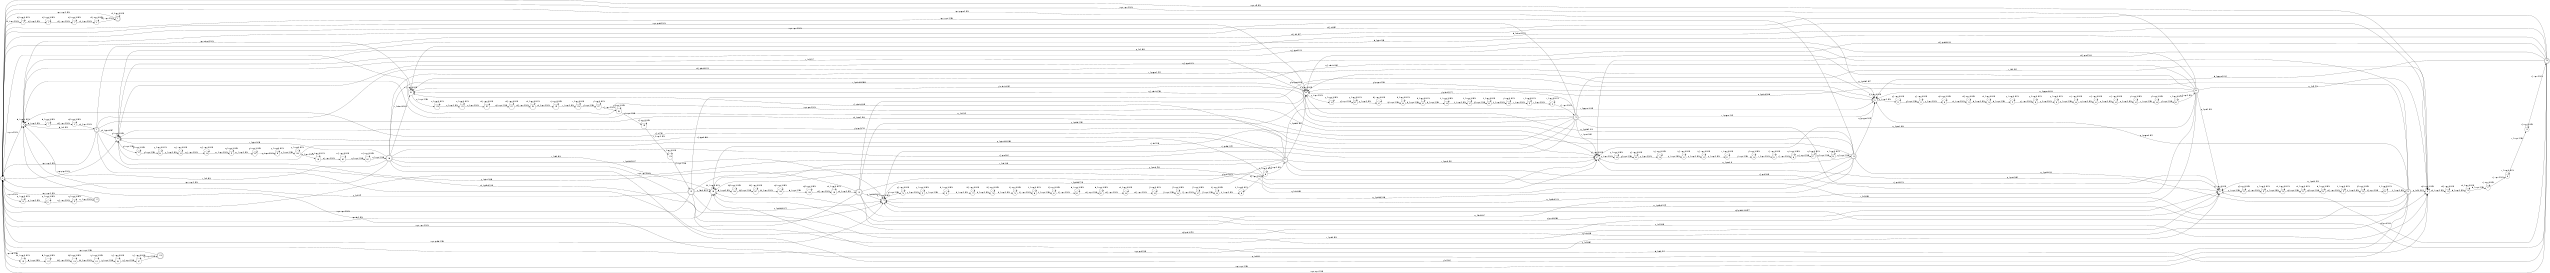

In [42]:
b = generate_bigram_wfst(3, even_dict, bigram_probs)
b.set_input_symbols(state_table)
b.set_output_symbols(word_table)
b.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=300','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [43]:
detb = fst.determinize(b)
detb = detb.minimize(allow_nondet=True)

In [44]:
# errors_sum = 0
# utterance_c = 0
# words_c = 0
# t = 0
# for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
#         #if utterances < 10:                                                                       # audio files
#         utterance_c+=1
#         decoder = MyViterbiDecoder(detb, wav_file)
    
#         if utterance_c < 10:
#             %time t += decoder.decode()
#         else:
#                 t += decoder.decode()
#         (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
#         transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
#         error_counts = wer.compute_alignment_errors(transcription, words)
#         word_count = len(transcription.split())
#         if utterance_c < 5:
#             print(error_counts, word_count)     # you'll need to accumulate these
#             print (words)
#             print(transcription)
#         errors_sum += sum(error_counts)
#         words_c += word_count
        
# print(errors_sum, utterance_c, words_c, t)

In [45]:
# best performance from experiments
errors_sum = 0
utterance_c = 0
words_c = 0
t = 0
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
        #if utterances < 10:                                                                       # audio files
        utterance_c+=1
        decoder = PruningViterbiDecoder(detb, wav_file, pruning_threshold =1.1)
    
        if utterance_c < 10:
            %time t += decoder.decode()
        else:
                t += decoder.decode()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
        transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())
        if utterance_c < 5:
            print(error_counts, word_count)     # you'll need to accumulate these
            print (words)
            print(transcription)
        errors_sum += sum(error_counts)
        words_c += word_count
        
print(errors_sum, utterance_c, words_c, t)

CPU times: user 1.59 s, sys: 24.3 ms, total: 1.61 s
Wall time: 1.62 s
(2, 0, 0) 5
the picked piper of peter
a pickled piper of peter
CPU times: user 509 ms, sys: 0 ns, total: 509 ms
Wall time: 510 ms
(0, 0, 0) 2
where's peter
where's peter
CPU times: user 821 ms, sys: 0 ns, total: 821 ms
Wall time: 822 ms
(0, 1, 0) 4
peter picked peck
peter picked a peck
CPU times: user 860 ms, sys: 0 ns, total: 860 ms
Wall time: 860 ms
(0, 0, 0) 3
where's the peppers
where's the peppers
CPU times: user 1.2 s, sys: 676 µs, total: 1.2 s
Wall time: 1.2 s
CPU times: user 3.25 s, sys: 0 ns, total: 3.25 s
Wall time: 3.25 s
CPU times: user 2.12 s, sys: 5.96 ms, total: 2.13 s
Wall time: 2.13 s
CPU times: user 2.36 s, sys: 967 µs, total: 2.36 s
Wall time: 2.36 s
CPU times: user 1.81 s, sys: 0 ns, total: 1.81 s
Wall time: 1.81 s
1148 318 2434 26492682


In [ ]:
s = generate_sil_wfst(3, even_dict)
s.set_input_symbols(state_table)
s.set_output_symbols(word_table)
sdet = fst.determinize(s)
sdet = sdet.minimize()

In [ ]:
errors_sum = 0
utterance_c = 0
words_c = 0
t = 0
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
        #if utterances < 10:                                                                       # audio files
        utterance_c+=1
        decoder = PruningViterbiDecoder(b, wav_file, pruning_threshold =1.1)
    
        if utterance_c < 10:
            %time t += decoder.decode()
        else:
                t += decoder.decode()
        (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
        transcription = read_transcription(wav_file)                                           # to return the words along the best path
       
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())
        if utterance_c < 5:
            print(error_counts, word_count)     # you'll need to accumulate these
            print (words)
            print(transcription)
        errors_sum += sum(error_counts)
        words_c += word_count
        
print(errors_sum, utterance_c, words_c, t)